In [69]:
import torch
import pyro
import json
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pandas as pd
import numpy as np

from ESN import esnet
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive

# Time-series forecasting

## Train ESN

Tr: 4882, Val: 1047, Te: 1047
train_embedding shape: (4882, 20)
Test MSE 0.196


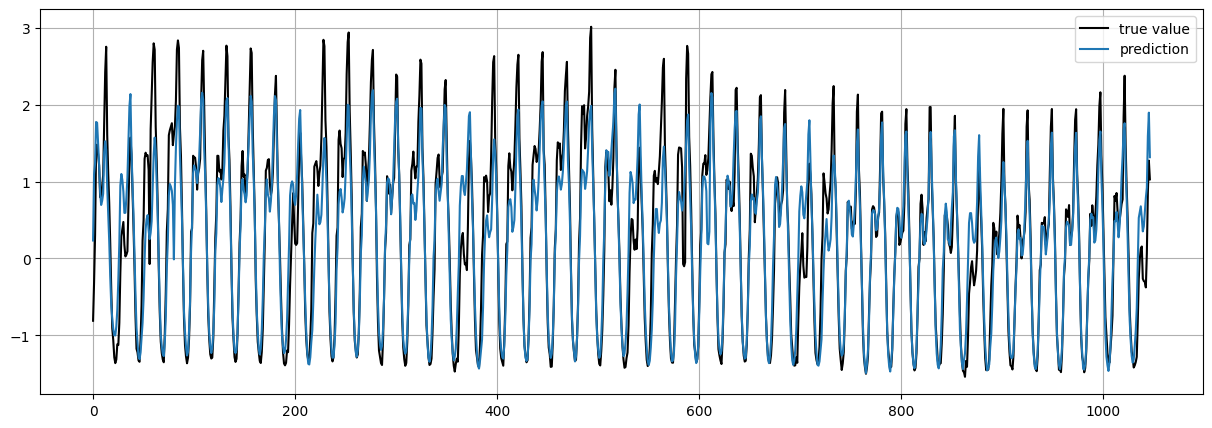

In [2]:
forecast_horizon = 24 

mat = loadmat('dataset/TS_Acea.mat')  # load mat-file
ACEA_data = mat['X'] # original resolution (1 = 10 mins)
ACEA_data = ACEA_data[::6] 
ACEA_data = ACEA_data[:7000] 

X = ACEA_data[:-forecast_horizon]
Y = ACEA_data[forecast_horizon:]

# Set ESN hyperparams
config = json.load(open('ESN/configs/ESN_hyperparams.json', 'r'))

Xtr, Ytr, Xval, Yval, Xte, Yte = esnet.generate_datasets(X, Y, test_percent = 0.15, val_percent = 0.15)
print("Tr: {:d}, Val: {:d}, Te: {:d}".format(Xtr.shape[0], Xval.shape[0], Xte.shape[0]))

# Train and compute predictions
Yte_pred, _, _, train_embedding, _, val_embedding, _, test_embedding = esnet.run_from_config_return_states(Xtr, Ytr, 
                                                                                                            Xte, Yte, 
                                                                                                            config, 
                                                                                                            validation=True,
                                                                                                            Xval=Xval,
                                                                                                            Yval=Yval)
print("train_embedding shape:", train_embedding.shape)
print('Test MSE {:.3f}'.format(mean_squared_error(Yte_pred, Yte)))

# Plot results
fig = plt.figure(figsize=(15,5))
plt.plot(Yte, label='true value', color='k')
plt.plot(Yte_pred, label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()  
plt.show()

## Bayesian regression

In [3]:
n_dims = train_embedding.shape[1]
dtype = 'float32'
train_embedding = train_embedding.astype(dtype)
train_embedding = torch.from_numpy(train_embedding)
# val_embedding = val_embedding.astype(dtype)
test_embedding = test_embedding.astype(dtype)
test_embedding = torch.from_numpy(test_embedding)
Ytr = Ytr.astype(dtype).squeeze()
Ytr = torch.from_numpy(Ytr)

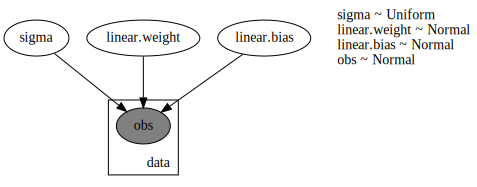

In [4]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[torch.nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 10.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean # do I need the mean?

model = BayesianRegression(n_dims, 1)
pyro.render_model(model, model_args=(train_embedding, Ytr), render_distributions=True)

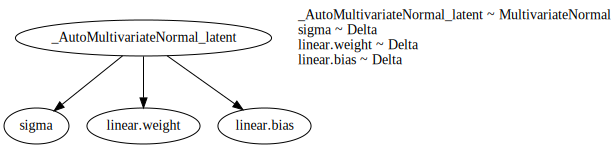

In [5]:
guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
pyro.render_model(guide, model_args=(train_embedding, Ytr), render_distributions=True)

Print starting guide's parameters:

In [6]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoMultivariateNormal.loc [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
AutoMultivariateNormal.scale [0.09999998 0.09999998 0.09999998 0.09999998 0.09999998 0.09999998
 0.09999998 0.09999998 0.09999998 0.09999998 0.09999998 0.09999998
 0.09999998 0.09999998 0.09999998 0.09999998 0.09999998 0.09999998
 0.09999998 0.09999998 0.09999998 0.09999998]
AutoMultivariateNormal.scale_tril [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.

In [7]:
adam = Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

num_iterations = 1500

# pyro.clear_param_store() # why do we need to clear the param store first?
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(train_embedding, Ytr)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / Ytr.shape[0]))

guide.requires_grad_(False)

[iteration 0001] loss: 2.4702
[iteration 0101] loss: 0.6545
[iteration 0201] loss: 0.6190
[iteration 0301] loss: 0.6197
[iteration 0401] loss: 0.6197
[iteration 0501] loss: 0.6200
[iteration 0601] loss: 0.6214
[iteration 0701] loss: 0.6200
[iteration 0801] loss: 0.6195
[iteration 0901] loss: 0.6198
[iteration 1001] loss: 0.6182
[iteration 1101] loss: 0.6201
[iteration 1201] loss: 0.6202
[iteration 1301] loss: 0.6204
[iteration 1401] loss: 0.6221
AutoMultivariateNormal.loc Parameter containing:
tensor([-3.0693e+00,  3.8696e-01, -3.3657e-01, -1.1533e-01,  2.9837e-01,
         1.7950e-02, -1.2603e-01,  8.7331e-02,  1.7021e-02, -4.0206e-02,
        -1.6983e-01, -1.6609e-01,  2.9798e-01,  3.4396e-01,  4.5906e-01,
         3.7137e-01,  8.7873e-01, -1.1453e+00,  9.1188e-01,  1.1153e+00,
         9.0659e-01,  2.0878e-03])
AutoMultivariateNormal.scale tensor([0.0128, 0.0027, 0.0046, 0.0090, 0.0132, 0.0177, 0.0309, 0.0267, 0.0380,
        0.0383, 0.0449, 0.0528, 0.0498, 0.0599, 0.0707, 0.0817, 0

Check that the guide's parameters changed:

In [ ]:

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

Print 5 sampled values of the regression parameters

In [29]:
# samples = {}
sigmas = []
biases = []
weights = []
for n in range(5):
    sample = guide()
    sigmas.append(sample["sigma"].numpy())
    biases.append(sample["linear.bias"].squeeze().numpy())
    weights.append(sample["linear.weight"].squeeze())

weights = torch.stack(weights).T

samples = {"sigma" : sigmas, "bias" : biases}

for i in range(weights.shape[0]):
    samples[f"w_{i}"] = weights[i].tolist()

In [30]:
regr_df = pd.DataFrame(samples)
regr_df.head()

,sigma,bias,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,...,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19
0,0.44761062,-0.0024254825,0.387649,-0.332219,-0.107545,0.316247,-0.009872,-0.138068,0.135047,-0.013515,...,-0.148022,0.294484,0.231940,0.458253,0.377077,0.686422,-1.078942,0.978117,1.164654,0.933220
1,0.44028625,0.009833112,0.382075,-0.340016,-0.117716,0.299112,0.014044,-0.089122,0.087107,0.076934,...,-0.176643,0.287719,0.333276,0.475154,0.322130,0.822659,-1.181671,0.960583,1.225336,0.958417
2,0.44733688,0.0009513742,0.386506,-0.330144,-0.112514,0.296404,0.003367,-0.130173,0.079430,0.031642,...,-0.184889,0.176088,0.307579,0.365036,0.414981,0.881307,-0.991255,1.216148,0.879593,1.009030
3,0.44605166,-0.00042279484,0.387590,-0.328873,-0.108909,0.300435,0.014636,-0.155221,0.061061,0.023181,...,-0.197336,0.238287,0.315005,0.474619,0.384816,1.148885,-1.151604,0.889960,1.167751,0.913060
4,0.432586,0.0064557856,0.386176,-0.349955,-0.130538,0.313961,0.038563,-0.129281,0.085127,0.038187,...,-0.214849,0.395653,0.412503,0.405858,0.249342,0.789153,-1.237900,0.923972,1.094885,0.586734


Make predictions

In [35]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)(x=test_embedding, y=None)

In [ ]:
pred_df = pd.DataFrame(predictive["obs"])
pred_stats = pred_df.describe(percentiles=[0.05,0.5,0.95]).transpose()
pred_stats = pred_stats[["mean", "std", "5%", "95%"]]

In [68]:
predictive["obs"].shape

torch.Size([1000, 1047])

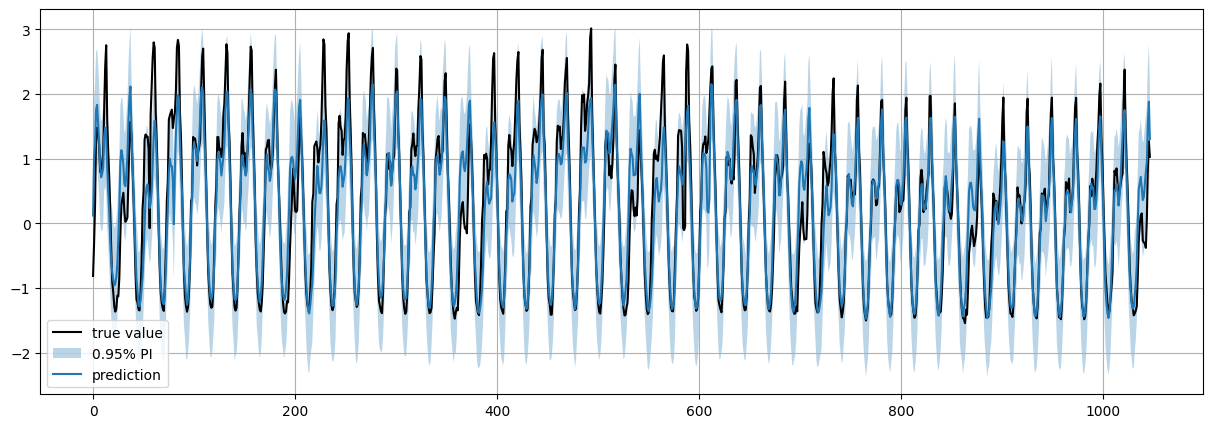

In [73]:
target_interval = 0.95
q_low, q_hi = np.quantile(predictive["obs"].numpy().squeeze(), [(1-target_interval)/2, 1-(1-target_interval)/2], axis=0)
mean = np.mean(predictive["obs"].numpy().squeeze(), axis=0)

fig = plt.figure(figsize=(15,5))
plt.plot(Yte, label='true value', color='k')
plt.fill_between(np.arange(predictive["obs"].shape[1]), q_low, q_hi, alpha=0.3, label=str(target_interval)+'% PI')
plt.plot(mean, label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()  
plt.show()

In [40]:
predictive["linear.weight"][0]

tensor([[[ 0.3870, -0.3452, -0.1228,  0.2914,  0.0321, -0.1477,  0.1168,
          -0.0043, -0.0691, -0.1980, -0.1622,  0.3232,  0.4902,  0.4681,
           0.2152,  0.8440, -1.1218,  0.9171,  1.1346,  0.8066]]])